In [192]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

# Step 1: Read data
train = pd.read_excel('train.xls')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print('Shape of the train data with numerical features:', train.shape)
train.fillna(0,inplace=True)

#test = pd.read_excel('test.xls')
#test = test.select_dtypes(exclude=['object'])
#test.fillna(0,inplace=True)

Shape of the train data with all features: (896, 11)
Shape of the train data with numerical features: (896, 11)


In [193]:
# Step 2: Outliers
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("\nNumber of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])


Number of Outliers: 90
Number of rows without outliers: 806


In [194]:
# Step 3: Preprocessing
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
#mat_test  = np.matrix(test)
mat_y = np.array(train.SalePrice).reshape((train.shape[0],1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

#prepro_test = MinMaxScaler()
#prepro_test.fit(mat_test)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
#test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train)

train.head()

,SalePrice,area,height,room,direction,hall,toilet,fitment,p_date,lng2,lat2
0,0.167677,0.383393,0.500000,0.4,0.0,0.5,0.500000,1.0,0.955752,0.0,0.942266
1,0.167677,0.383393,0.500000,0.4,0.0,0.5,0.500000,1.0,0.973451,0.0,0.942266
2,0.158731,0.398527,0.653846,0.4,0.0,0.5,0.250000,1.0,0.973451,0.0,0.942266
3,0.141538,0.454018,0.884615,0.6,0.0,0.5,0.392643,1.0,0.008850,0.0,0.942266
4,0.201331,0.489331,0.500000,0.4,0.0,0.5,0.500000,1.0,0.061947,0.0,0.942266


In [195]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = y_train.merge(pd.DataFrame(x_train, columns = FEATURES), left_index = True, right_index = True)
training_set.head()

,SalePrice,area,height,room,direction,hall,toilet,fitment,p_date,lng2,lat2
361,0.147672,0.192151,0.192308,0.2,0.0,0.0,0.25,1.0,0.486726,1.000000,0.000000
760,0.081019,0.630581,0.538462,0.4,0.0,0.5,0.25,1.0,0.778761,0.589659,1.000000
544,0.129015,0.514554,0.538462,0.4,0.0,0.5,0.25,1.0,0.212389,0.589659,1.000000
615,0.000379,0.438884,0.769231,0.4,0.0,0.5,0.25,1.0,0.017699,0.589659,1.000000
18,0.162248,0.383393,0.500000,0.4,0.0,0.0,0.25,1.0,0.557522,0.000000,0.942266


In [196]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = y_test.merge(pd.DataFrame(x_test, columns = FEATURES), left_index = True, right_index = True)
testing_set.head()

,SalePrice,area,height,room,direction,hall,toilet,fitment,p_date,lng2,lat2
697,0.137395,0.166473,0.730769,0.2,0.0,0.5,0.250000,1.0,0.070796,0.589659,1.00000
296,0.176161,0.295667,0.192308,0.2,0.0,0.5,0.392643,1.0,0.690265,0.239604,0.44037
227,0.106178,0.484286,0.192308,0.6,0.0,0.5,0.250000,1.0,0.725664,0.239604,0.44037
336,0.127497,0.459063,0.192308,0.4,0.0,0.5,0.392643,1.0,0.132743,1.000000,0.00000
537,0.128761,0.478737,0.538462,0.4,0.0,0.5,0.500000,1.0,0.973451,0.589659,1.00000


In [197]:
# Step 4: Deep Neural Network
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, 
                                          hidden_units=[200, 100, 50, 25, 12])
                                          # optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [198]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x12b87f950>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name=u'area', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'height', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'room', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'direction', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'hall', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'toilet', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'fitment', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name=u'p_date', dimensi

In [199]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [200]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.000772


In [201]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

In [202]:
import matplotlib
import matplotlib.pyplot as plt

predictions = prepro_y.inverse_transform(np.array(predictions).reshape(testing_set.shape[0],1))

In [203]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice
reality.head()

,SalePrice
0,43333.333333
1,53732.040649
2,34959.349593
3,40677.966102
4,41017.227235


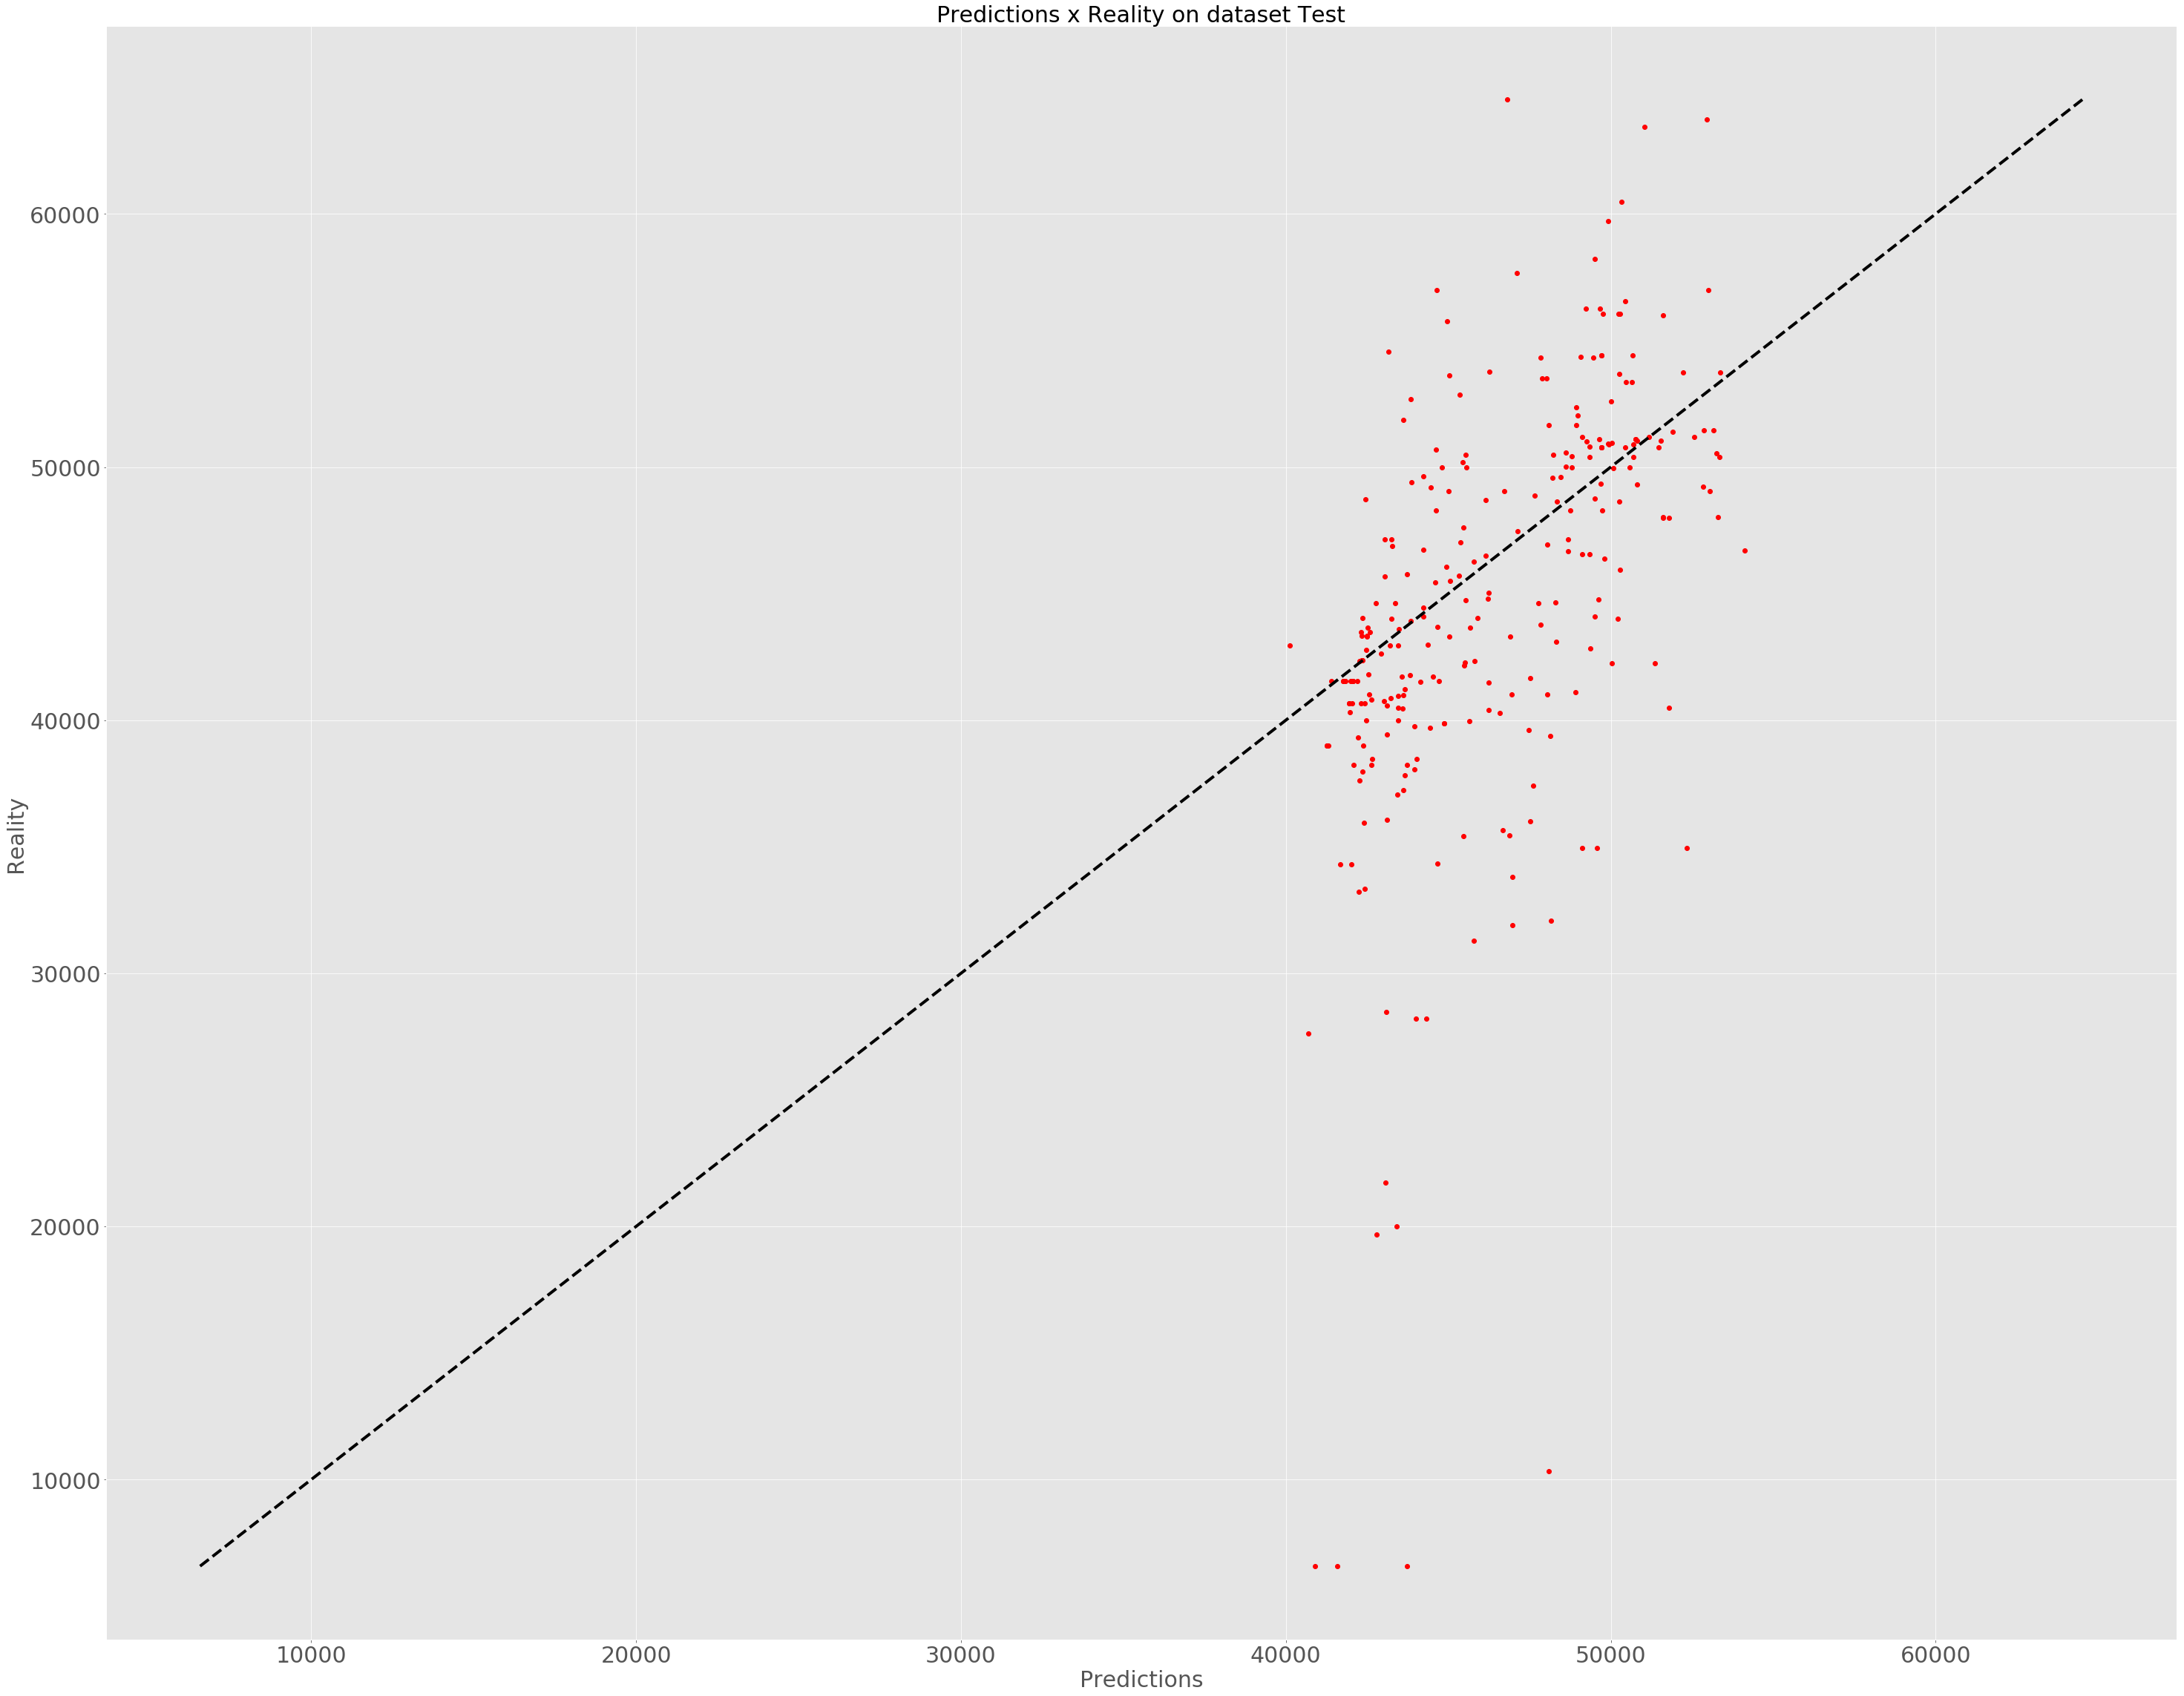

In [205]:
reality = np.matrix(reality)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))
    
plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()